This notebook replicates the second experiment with LeNet on MNIST dataset from our paper "MARS: Masked Automatic Ranks Selection in Tensor Decompositions".

Compression mode: **compress** ($\pi = 10^{-2}$, $\alpha = 0$).

**Preliminaries**

In [1]:
import os

os.chdir("../main")

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import torch
import numpy as np
import random

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

from mars import MARS, MARSLoss, get_MARS_attr, set_MARS_attr
from models import LeNet

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [4]:
seed = 228  # set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Model and hyperparameters definition**

In [5]:
# Compression modes parameters
modes_dict = {
    "base": dict(pi=np.nan, alpha=np.nan),
    "compress": dict(pi=1e-2, alpha=0)
}

In [6]:
# Hyperparameters section
# In this experiment, we take enough epochs to guarantee complete convergence.
# One can take fewer but adjust the temperature annealing schedule appropriately.
n_epochs = 50
batch_size = 128
lr = 1e-3
weight_decay = 0
gamma = 0.94
temp_anneal = lambda t: max(1e-2, gamma * t)

In [7]:
data_dir = "/home/sergej/data"
test_batch = 2048

# MNIST Dataset (Images and Labels)
trainset = datasets.MNIST(root=data_dir,
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

testset = datasets.MNIST(root=data_dir,
                         train=False,
                         transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=testset,
                                         batch_size=test_batch,
                                         shuffle=False)

**Functions definition**

In [8]:
def train_model(model_idx, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"../models/MNIST-LeNet/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = LeNet(config, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    mars_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    cross_entropy = nn.CrossEntropyLoss()
    criterion = MARSLoss(model, len(trainset), cross_entropy)
    
#     optimizer_logits = optim.Adam(
#         [p for n, p in model.named_parameters() if "logits_list" in n],
#         lr=1e-4 # logits with custom lr and without wd
#     )
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in model.named_parameters() if "tensor_model.parameters" in n],
#          'lr': lr},  # cores without wd
#         {'params': [p for n, p in model.named_parameters() if ("logits_list" not in n) and ("tensor_model.parameters" not in n)], 
#          'lr': lr, 'weight_decay': weight_decay},  # other parameters with wd
#     ]
#     optimizer = optim.AdamW(optimizer_grouped_parameters)
    optimizer = optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **{
#         "steps_per_epoch": len(trainloader),
#         "epochs": n_epochs,
#         "anneal_strategy": "cos",
#         "max_lr": lr,
#         "pct_start": 0.1
#     })

    print("Training...")
    losses = []
    log_step = len(trainloader)
    best_train_acc = 0
    best_test_acc = 0
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        losses.append(0.0)
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
#             optimizer_logits.zero_grad()
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses[-1] += loss.item()
            loss.backward()
#             optimizer_logits.step()
            optimizer.step()
#             scheduler.step()

            # update statistics
            with torch.no_grad():
                running_loss += loss.item()
                predicted = outputs.argmax(-1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_acc = correct / total
        try:
            test_acc = eval_model(model)
        except RuntimeError:
            test_acc = np.nan
        temp = get_MARS_attr(model, "temperature")
        with torch.no_grad():
            logits = [l.cpu().numpy() for layer in mars_layers for l in layer.phi_logits_list]
            logits = np.concatenate(logits)
            logits_mean = np.mean(logits)
            logits_std = np.std(logits)
        print('[%d] \t Loss: %.3f \t Train Acc: %.2f%% \t Test Acc: %.2f%% \t T: %.3f \t logits mean: %.3f \t logits std: %.3f' % (
            epoch + 1, 
            running_loss / log_step,
            100 * train_acc,
            100 * test_acc, 
            np.nan if temp is None else temp,
            logits_mean, logits_std
        ))
                
        losses[-1] /= i + 1
        
        scheduler.step()
        
        if save:
            if train_acc > best_train_acc:
                torch.save(model.state_dict(), model_path[:-3] + "-best_train.pt")
                best_train_acc = train_acc
                best_train_epoch = epoch + 1
            if test_acc > best_test_acc:
                torch.save(model.state_dict(), model_path[:-3] + "-best_test.pt")
                best_test_acc = test_acc
                best_test_epoch = epoch + 1
        
        temp = get_MARS_attr(model, "temperature")
        if temp is not None:
            new_temp = temp_anneal(temp)
            set_MARS_attr(model, "temperature", new_temp)

    losses = np.array(losses)
    print('Finished Training.')
    print("Best train accuracy:\t%.2f%% on epoch %d" % (100 * best_train_acc, best_train_epoch))
    print("Best test accuracy:\t%.2f%% on epoch %d" % (100 * best_test_acc, best_test_epoch))
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
def eval_model(model):
    "Evaluate a single model on test set."
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def eval_ensemble(models):
    "Evaluate the whole ensemble on test set."
    for model in models:
        model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = torch.stack([model(images) for model in models])
            outputs = torch.softmax(outputs, -1)
            outputs = outputs.mean(0)
                
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

**MARS training**

In [12]:
from dataclasses import dataclass

@dataclass
class MNISTLeNetConfig:
    mars_enabled = True

config = MNISTLeNetConfig()

In [13]:
%%time

model, loss = train_model(0, mode="compress")
acc = eval_model(model)
print(f"Accuracy of base model:\t%.2f%%" % (100 * acc))

Model path:  ../models/MNIST-LeNet/compress/0-model.pt
Training...
[1] 	 Loss: 0.961 	 Train Acc: 67.77% 	 Test Acc: 93.35% 	 T: 0.100 	 logits mean: 0.061 	 logits std: 0.031
[2] 	 Loss: 0.370 	 Train Acc: 88.94% 	 Test Acc: 96.03% 	 T: 0.094 	 logits mean: 0.107 	 logits std: 0.046
[3] 	 Loss: 0.267 	 Train Acc: 92.30% 	 Test Acc: 97.11% 	 T: 0.088 	 logits mean: 0.147 	 logits std: 0.060
[4] 	 Loss: 0.213 	 Train Acc: 94.28% 	 Test Acc: 97.64% 	 T: 0.083 	 logits mean: 0.179 	 logits std: 0.072
[5] 	 Loss: 0.184 	 Train Acc: 94.78% 	 Test Acc: 97.98% 	 T: 0.078 	 logits mean: 0.202 	 logits std: 0.081
[6] 	 Loss: 0.167 	 Train Acc: 95.47% 	 Test Acc: 98.15% 	 T: 0.073 	 logits mean: 0.229 	 logits std: 0.092
[7] 	 Loss: 0.147 	 Train Acc: 95.99% 	 Test Acc: 98.38% 	 T: 0.069 	 logits mean: 0.253 	 logits std: 0.100
[8] 	 Loss: 0.134 	 Train Acc: 96.43% 	 Test Acc: 98.32% 	 T: 0.065 	 logits mean: 0.270 	 logits std: 0.107
[9] 	 Loss: 0.126 	 Train Acc: 96.57% 	 Test Acc: 98.50% 	 T:

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


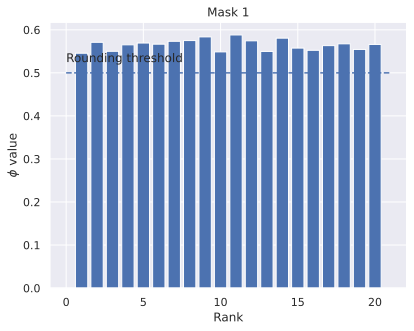

#nz ranks: 20/20


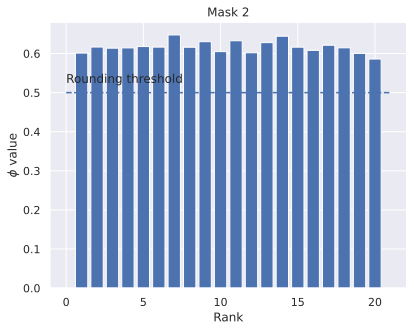

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


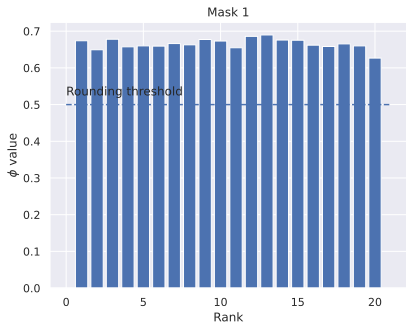

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


In [14]:
comp = get_comp_info(model)

In [15]:
def time_model(model, device):
    model = model.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)

%timeit time_model(model, "cuda")

230 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit time_model(model, "cpu")

1.49 s ± 8.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**MARS ensemble training**

In [17]:
n_models = 5  # set the number of models in ensemble
mode = "compress"  # set the compression mode
models, losses = [], []

In [18]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    model, loss = train_model(k, mode)
    losses.append(loss)
    models.append(model)
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ../models/MNIST-LeNet/compress/1-model.pt
Training...
[1] 	 Loss: 0.909 	 Train Acc: 69.90% 	 Test Acc: 94.07% 	 T: 0.100 	 logits mean: 0.056 	 logits std: 0.036
[2] 	 Loss: 0.393 	 Train Acc: 88.30% 	 Test Acc: 95.70% 	 T: 0.094 	 logits mean: 0.107 	 logits std: 0.054
[3] 	 Loss: 0.277 	 Train Acc: 92.11% 	 Test Acc: 96.90% 	 T: 0.088 	 logits mean: 0.141 	 logits std: 0.064
[4] 	 Loss: 0.222 	 Train Acc: 93.80% 	 Test Acc: 96.88% 	 T: 0.083 	 logits mean: 0.170 	 logits std: 0.074
[5] 	 Loss: 0.202 	 Train Acc: 94.29% 	 Test Acc: 97.85% 	 T: 0.078 	 logits mean: 0.199 	 logits std: 0.085
[6] 	 Loss: 0.173 	 Train Acc: 95.31% 	 Test Acc: 97.85% 	 T: 0.073 	 logits mean: 0.222 	 logits std: 0.089
[7] 	 Loss: 0.157 	 Train Acc: 95.73% 	 Test Acc: 98.03% 	 T: 0.069 	 logits mean: 0.246 	 logits std: 0.098
[8] 	 Loss: 0.148 	 Train Acc: 95.87% 	 Test Acc: 98.30% 	 T: 0.065 	 logits mean: 0.265 	 logits std: 0.104
[9] 	 Loss: 0.144 	 Train Acc: 96.05% 	 Tes

[22] 	 Loss: 0.084 	 Train Acc: 97.64% 	 Test Acc: 98.73% 	 T: 0.027 	 logits mean: 0.412 	 logits std: 0.190
[23] 	 Loss: 0.081 	 Train Acc: 97.76% 	 Test Acc: 98.61% 	 T: 0.026 	 logits mean: 0.417 	 logits std: 0.192
[24] 	 Loss: 0.081 	 Train Acc: 97.75% 	 Test Acc: 98.68% 	 T: 0.024 	 logits mean: 0.422 	 logits std: 0.194
[25] 	 Loss: 0.078 	 Train Acc: 97.89% 	 Test Acc: 98.75% 	 T: 0.023 	 logits mean: 0.427 	 logits std: 0.195
[26] 	 Loss: 0.075 	 Train Acc: 97.97% 	 Test Acc: 98.69% 	 T: 0.021 	 logits mean: 0.430 	 logits std: 0.196
[27] 	 Loss: 0.073 	 Train Acc: 98.00% 	 Test Acc: 98.66% 	 T: 0.020 	 logits mean: 0.433 	 logits std: 0.197
[28] 	 Loss: 0.072 	 Train Acc: 98.00% 	 Test Acc: 98.69% 	 T: 0.019 	 logits mean: 0.436 	 logits std: 0.198
[29] 	 Loss: 0.073 	 Train Acc: 98.04% 	 Test Acc: 98.73% 	 T: 0.018 	 logits mean: 0.438 	 logits std: 0.199
[30] 	 Loss: 0.073 	 Train Acc: 98.00% 	 Test Acc: 98.85% 	 T: 0.017 	 logits mean: 0.441 	 logits std: 0.200
[31] 	 Los

[44] 	 Loss: 0.056 	 Train Acc: 98.44% 	 Test Acc: 99.01% 	 T: 0.010 	 logits mean: 0.483 	 logits std: 0.184
[45] 	 Loss: 0.055 	 Train Acc: 98.49% 	 Test Acc: 98.99% 	 T: 0.010 	 logits mean: 0.484 	 logits std: 0.185
[46] 	 Loss: 0.058 	 Train Acc: 98.40% 	 Test Acc: 99.03% 	 T: 0.010 	 logits mean: 0.485 	 logits std: 0.185
[47] 	 Loss: 0.056 	 Train Acc: 98.47% 	 Test Acc: 99.03% 	 T: 0.010 	 logits mean: 0.485 	 logits std: 0.185
[48] 	 Loss: 0.055 	 Train Acc: 98.57% 	 Test Acc: 99.03% 	 T: 0.010 	 logits mean: 0.486 	 logits std: 0.186
[49] 	 Loss: 0.053 	 Train Acc: 98.56% 	 Test Acc: 98.97% 	 T: 0.010 	 logits mean: 0.486 	 logits std: 0.186
[50] 	 Loss: 0.057 	 Train Acc: 98.44% 	 Test Acc: 98.99% 	 T: 0.010 	 logits mean: 0.487 	 logits std: 0.186
Finished Training.
Best train accuracy:	98.57% on epoch 48
Best test accuracy:	99.06% on epoch 42
Saved model parameters to disk.


Model number 4...
Model path:  ../models/MNIST-LeNet/compress/4-model.pt
Training...
[1] 	 Loss: 0

[13] 	 Loss: 0.112 	 Train Acc: 96.83% 	 Test Acc: 98.54% 	 T: 0.048 	 logits mean: 0.350 	 logits std: 0.147
[14] 	 Loss: 0.101 	 Train Acc: 97.19% 	 Test Acc: 98.44% 	 T: 0.045 	 logits mean: 0.361 	 logits std: 0.151
[15] 	 Loss: 0.096 	 Train Acc: 97.25% 	 Test Acc: 98.71% 	 T: 0.042 	 logits mean: 0.373 	 logits std: 0.154
[16] 	 Loss: 0.094 	 Train Acc: 97.45% 	 Test Acc: 98.68% 	 T: 0.040 	 logits mean: 0.382 	 logits std: 0.157
[17] 	 Loss: 0.094 	 Train Acc: 97.35% 	 Test Acc: 98.57% 	 T: 0.037 	 logits mean: 0.392 	 logits std: 0.161
[18] 	 Loss: 0.092 	 Train Acc: 97.41% 	 Test Acc: 98.64% 	 T: 0.035 	 logits mean: 0.399 	 logits std: 0.165
[19] 	 Loss: 0.091 	 Train Acc: 97.59% 	 Test Acc: 98.86% 	 T: 0.033 	 logits mean: 0.407 	 logits std: 0.167
[20] 	 Loss: 0.082 	 Train Acc: 97.70% 	 Test Acc: 98.79% 	 T: 0.031 	 logits mean: 0.414 	 logits std: 0.169
[21] 	 Loss: 0.082 	 Train Acc: 97.79% 	 Test Acc: 98.57% 	 T: 0.029 	 logits mean: 0.421 	 logits std: 0.170
[22] 	 Los

KeyboardInterrupt: 

Model number 1...

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


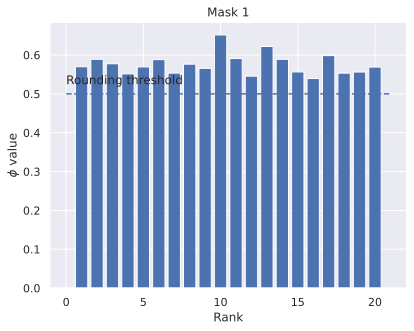

#nz ranks: 20/20


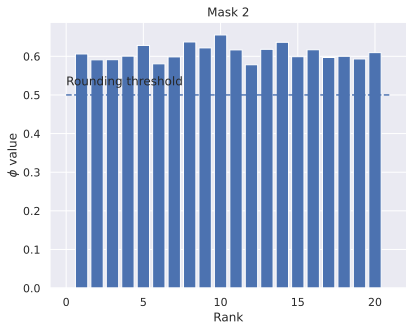

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


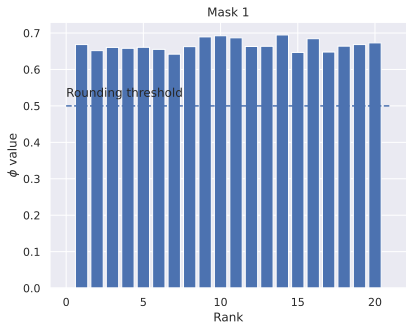

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 2...

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


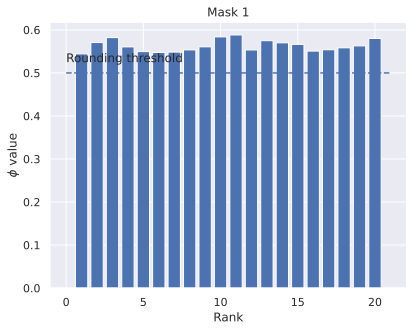

#nz ranks: 20/20


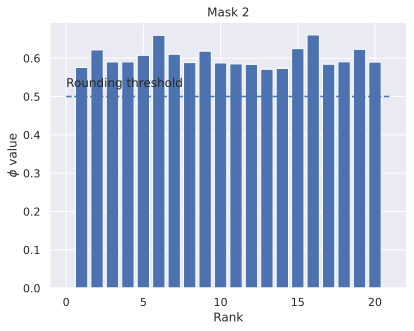

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


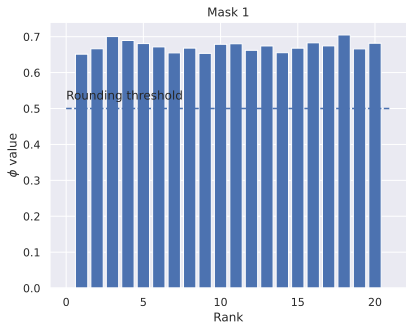

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 3...

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


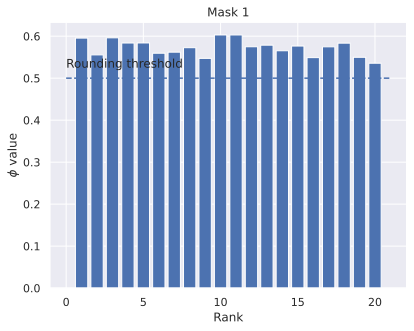

#nz ranks: 20/20


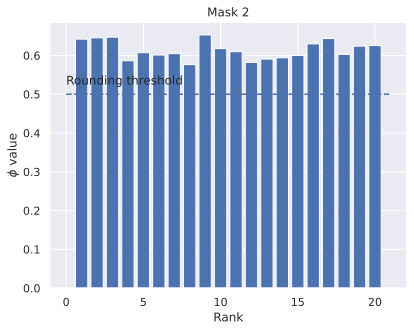

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


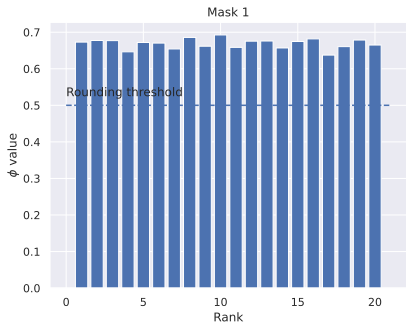

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 4...

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


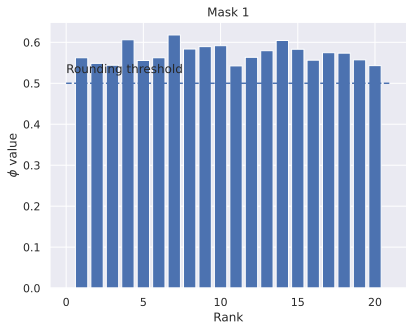

#nz ranks: 20/20


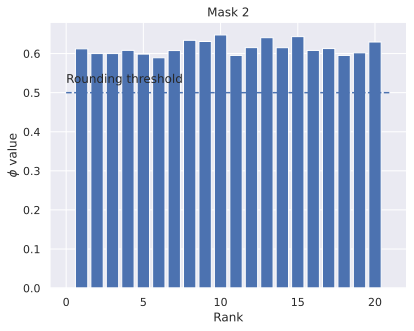

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


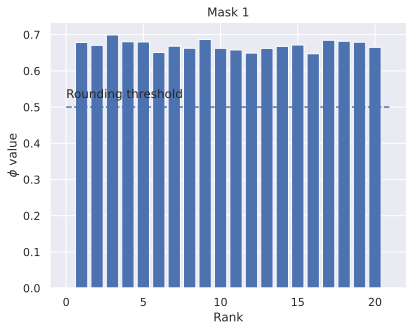

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 5...

Layer:  Tucker Conv2d: [64, 128, 5, 5] -> [64, 20]-[20, 20, 5, 5]-[20, 128]


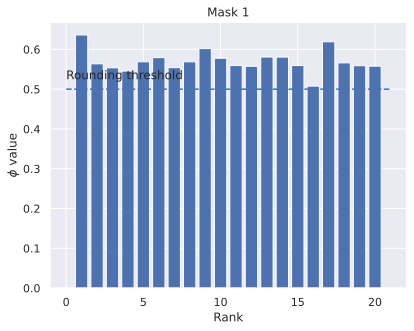

#nz ranks: 20/20


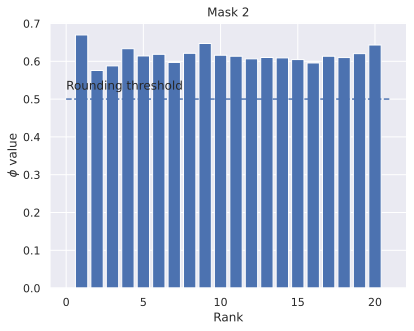

#nz ranks: 20/20

Compression:	14.798
Layer:  Factorized Linear: [3200, 120] -> [3200, 20]-[20, 120]


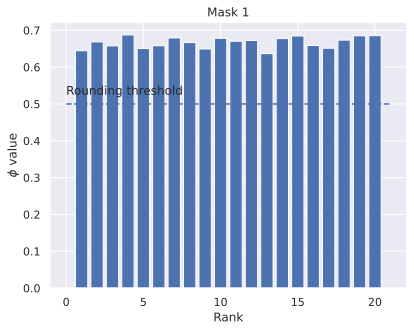

#nz ranks: 20/20

Compression:	5.783
Total compression:	7.101


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [19]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

In [20]:
accuracies = dict()

accuracies["marginal"] = []
for k, model in enumerate(models, 1):
    k_acc = eval_model(model)
    print(f"Accuracy of model {k}:\t%.2f%%" % (100 * k_acc))
    accuracies["marginal"].append(k_acc)
    
print()

ensemble_acc = eval_ensemble(models)
print('Accuracy of the ensemble:\t%.2f%%' % (100 * ensemble_acc))
accuracies["ensemble"] = ensemble_acc

Accuracy of model 1:	99.04%
Accuracy of model 2:	98.84%
Accuracy of model 3:	98.99%
Accuracy of model 4:	99.00%
Accuracy of model 5:	99.05%

Accuracy of the ensemble:	99.09%


In [22]:
np.std([99.04, 98.84, 98.99, 99.00, 99.05])

0.07552483035399588

In [ ]:
for k, comp in enumerate(comps, 1):
    print(f"Model {k} total compression:\t%.3f" % comp)